## Try moving the activation function after the batch normalization layer in conv. Does it make a difference? See what you can find out about what order is recommended, and why.

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks = (ImageBlock(cls = PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

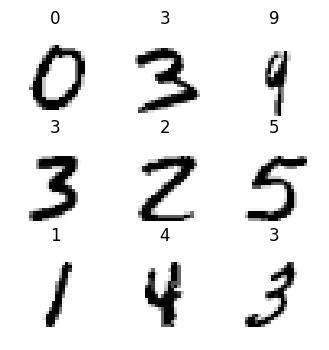

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        Flatten()
    )

In [ ]:
def fit(epochs = 1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy)
    learn.fit_one_cycle(epochs, lr)
    return learn

First activation then the `BatchNorm2d`

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act:
        layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)
learn = fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.109260,0.085607,0.973700,00:27
1,0.045833,0.034405,0.989700,00:28


In [ ]:
m1 = learn.model
m1[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

First `BatchNorm2d` then activation 

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)
learn = fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.106057,0.069768,0.978600,00:27
1,0.037472,0.031781,0.990400,00:31


**Conclusion :**<br>

`Accuracy`, `train_loss` and `valid_loss` is worse when the activation comes before batchnorm. Inutation some output of the activation might be cut-off by activation (i.e. nagative ones). So that they will have no effect(converted to `0`) in the batch norm layer. So the normalization will only act positve part of the network rather than complete set.

In [ ]:
t = torch.randn((3,5))
t

tensor([[-0.2837, -0.9316, -0.7214,  1.2527,  0.9261],
        [ 0.3938,  1.4345, -1.3526, -0.0744, -1.9580],
        [ 0.0965,  0.3851, -0.7389,  1.8008, -0.2670]])

In [ ]:
t_relu = F.relu(t)
t_relu

tensor([[0.0000, 0.0000, 0.0000, 1.2527, 0.9261],
        [0.3938, 1.4345, 0.0000, 0.0000, 0.0000],
        [0.0965, 0.3851, 0.0000, 1.8008, 0.0000]])

In [ ]:
mean = torch.mean(t_relu, dim=1, keepdim=True)
var = torch.var(t_relu, dim=1,  keepdim=True)
mean, var

(tensor([[0.4357],
         [0.3657],
         [0.4565]]),
 tensor([[0.3694],
         [0.3861],
         [0.5897]]))

In [ ]:
(t_relu - mean) * var

tensor([[-0.1609, -0.1609, -0.1609,  0.3017,  0.1811],
        [ 0.0109,  0.4127, -0.1412, -0.1412, -0.1412],
        [-0.2123, -0.0421, -0.2692,  0.7927, -0.2692]])

As the basic `normalization` is returing both positive and negative number. The positive number are way too big as it did not got clip.

In [ ]:
mean = torch.mean(t, dim=1, keepdim=True)
var = torch.var(t, dim=1,  keepdim=True)
mean, var

(tensor([[ 0.0484],
         [-0.3113],
         [ 0.2553]]),
 tensor([[0.9710],
         [1.8492],
         [0.9230]]))

In [ ]:
F.relu((t_relu - mean) * var)

tensor([[0.0000, 0.0000, 0.0000, 1.1694, 0.8522],
        [1.3039, 3.2284, 0.5757, 0.5757, 0.5757],
        [0.0000, 0.1198, 0.0000, 1.4265, 0.0000]])

As the basic `normalization` is returing positive number. The positive number are cliped as it got normalized previously.